In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import nltk
import re
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

import itertools
from gensim.models import Word2Vec, KeyedVectors
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
def get_cleaned_text2(fname, max_len=999999):
    all_words = []
    with open(fname, 'r') as f:
        for n, line in enumerate(f):
            if n and n<max_len:
                line_id, line_text = line.split('||')
                line_letters = re.sub("[^a-zA-Z -]", "", line_text) 
                line_letters_low = line_letters.lower()
                line_letters_low = stop_pattern.sub('', line_letters_low)
                line_words = line_letters_low.split()
                all_words.append(line_words)
                #all_words.append(line_letters_low)
                #print(len(all_words), len(line_letters_low))
    return all_words

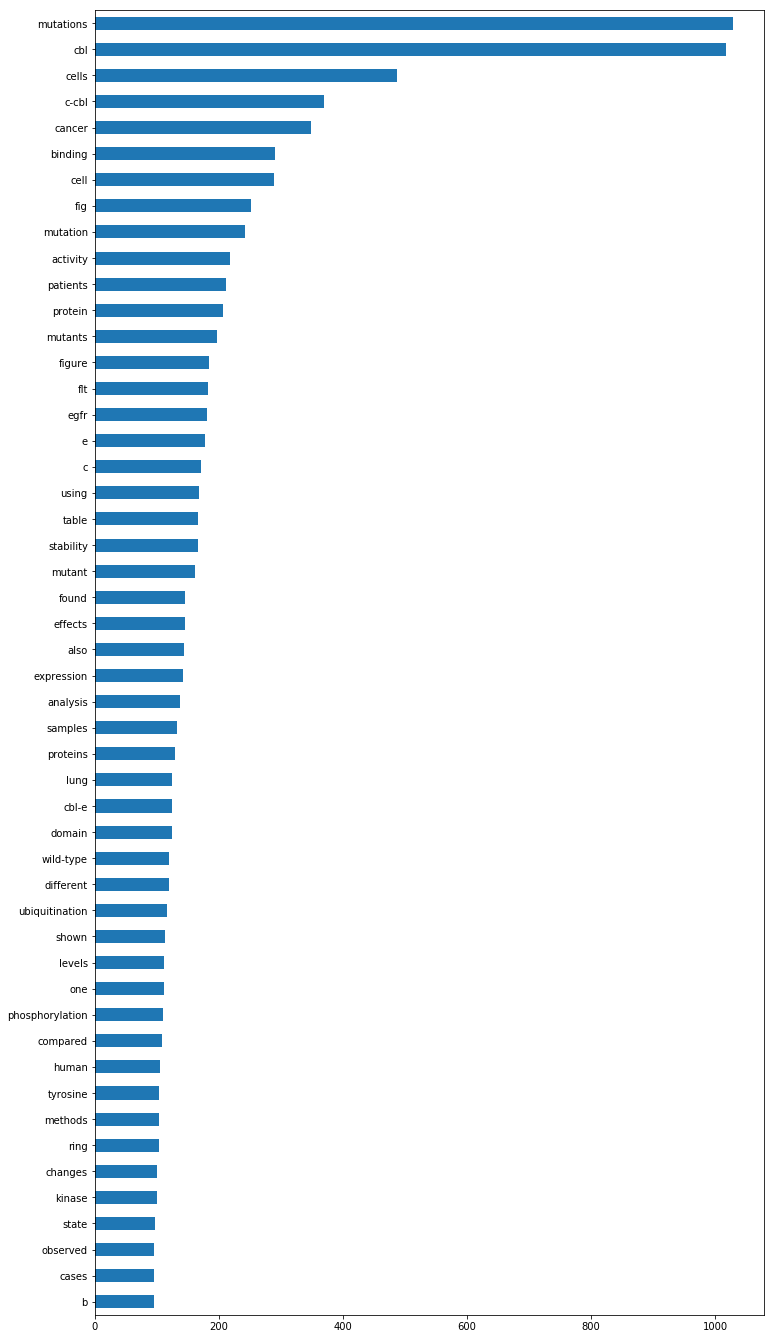

In [3]:
fname = '../data/training_text'
stop_pattern = re.compile(r'\b(' + r'|'.\
            join(stopwords.words('english')) + r')\b\s*')
train_text2 = get_cleaned_text2(fname,10)

flatw = [w for a in train_text2 for w in a]
x = pd.DataFrame(flatw)
fig = x[0].value_counts()[:50].plot(kind='barh', figsize=(12,24))
fig.axes.invert_yaxis()

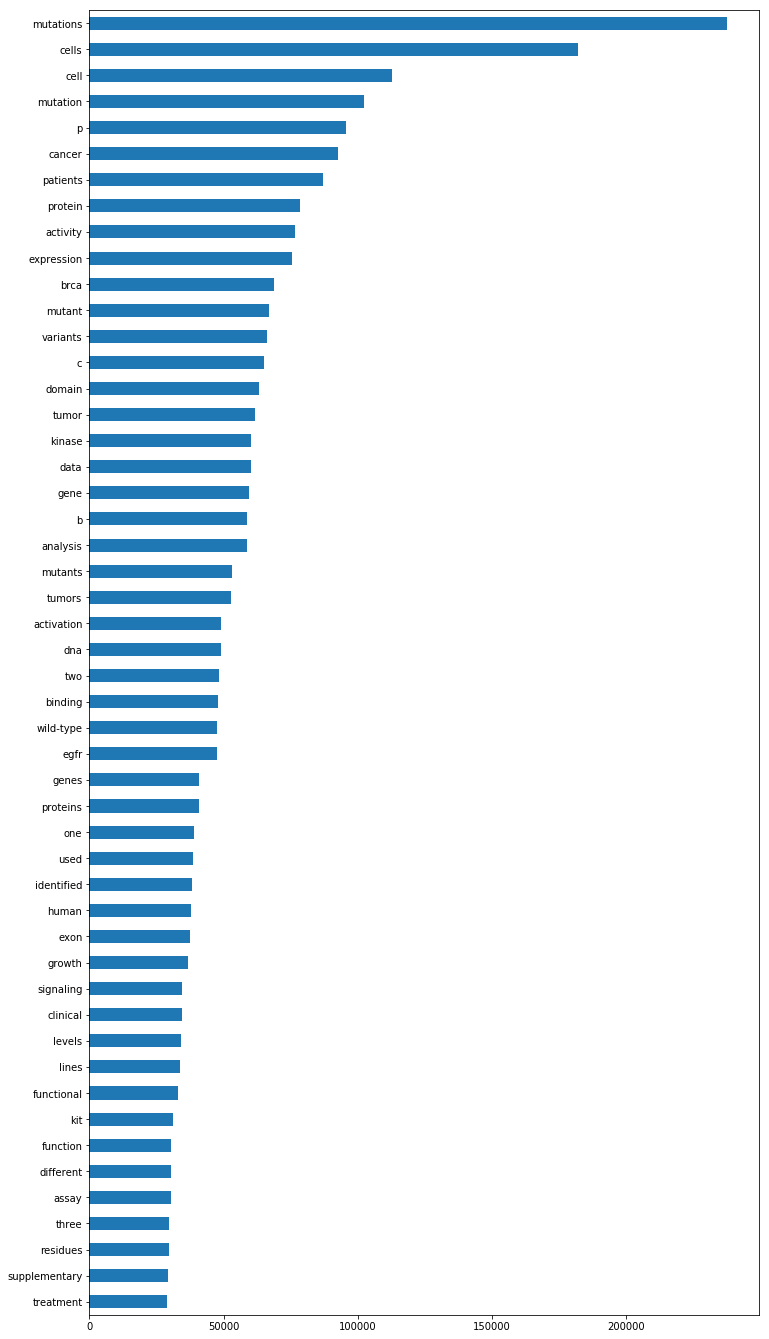

In [4]:
stop_words = ['et', 'al', 'fig', 'figs', 'figure', 'table', 'also',
            'using', 'found', 'observed', 'however', 'previous', 'study',
            'although', 'studies', 'several', 'showed', 'could', 
            'performed', 'known', 'methods', 'whether', 'materials',
            'known', 'analyzed', 'within', 'show', 'respectively', 
            'thus', 'therefore', 'tested', 'among', 'abstract', 
            'introduction', 'may', 'shown', 'results', 'interestingly',
            'either', 'similarly', 'furthermore', 'consistently', 
            'neither']

fname = '../data/training_text'
stop_pattern = re.compile(r'\b(' + r'|'.\
            join(stopwords.words('english')+stop_words) + r')\b\s*')
train_text2 = get_cleaned_text2(fname)

flatw = [w for a in train_text2 for w in a]
x = pd.DataFrame(flatw)
fig = x[0].value_counts()[:50].plot(kind='barh', figsize=(12,24))
fig.axes.invert_yaxis()

In [5]:
w2v_model = Word2Vec(train_text2, size=100, window=5, min_count=5, workers=4)

In [6]:
w2v_model.wv['gene']

array([-2.4133203 ,  1.67802548, -0.07623444,  1.59866464,  1.24386275,
        1.15537226,  3.48575044,  2.1572392 , -1.45823932, -0.61350572,
        0.45686743,  0.13171387, -0.49720836, -0.73309106, -2.31180644,
        0.15158182, -1.49861002, -0.68171519, -1.96071959, -4.15905046,
        0.59123093,  3.13722181, -1.46414673, -2.39183736, -0.03527386,
       -2.45305777, -4.29500532, -0.19720216,  0.55906147,  1.89124298,
        2.34620953, -0.76727659,  1.38298583,  0.57207465,  0.47911561,
       -1.7648654 ,  2.35869169, -3.80346441, -1.56342041,  2.12071848,
        1.10517395, -1.06179905, -2.90082479,  0.75733978,  1.0482018 ,
        1.91271746,  0.84182274, -2.1949861 ,  1.46218419, -0.88321459,
        0.7170788 , -4.45560884,  1.2063545 , -1.34810758,  0.18549944,
        1.32320821, -2.7375598 , -0.92525303,  1.69956338,  4.06609583,
        0.80229294,  3.08310199, -0.893484  ,  2.38786983,  2.22488117,
        0.62204617, -0.23316959, -1.19247115, -0.43725777,  2.72

In [7]:
w2v_model.wv.most_similar(positive='gene')

[('genes', 0.7361798882484436),
 ('locus', 0.6114547252655029),
 ('tmprss-erg', 0.5454087257385254),
 ('oncogene', 0.5436125993728638),
 ('unbalanced', 0.5249805450439453),
 ('loci', 0.5192455053329468),
 ('tmprsserg', 0.5180792212486267),
 ('oncogenes', 0.5129985809326172),
 ('tmprss', 0.5044249296188354),
 ('ewsratf', 0.5039467215538025)]

In [8]:
w2v_model.wv.most_similar(positive='cancer')

[('cancers', 0.7830120325088501),
 ('adenocarcinoma', 0.687116265296936),
 ('carcinoma', 0.6400411128997803),
 ('crc', 0.620227038860321),
 ('cancer-', 0.6112346649169922),
 ('carcinomas', 0.6077049970626831),
 ('adenocarcinomas', 0.6051579713821411),
 ('melanoma', 0.598968505859375),
 ('carcinogenesis', 0.5983567237854004),
 ('tumor', 0.598322331905365)]

In [9]:
w2v_model.wv.most_similar(positive='mutation')

[('mutations', 0.8221759796142578),
 ('substitution', 0.6659276485443115),
 ('variant', 0.6544451117515564),
 ('alteration', 0.5957878828048706),
 ('substitutions', 0.5446322560310364),
 ('mutational', 0.5356433987617493),
 ('mutant', 0.5339510440826416),
 ('mpm', 0.5329239368438721),
 ('polymorphism', 0.5122480392456055),
 ('ptyrhis', 0.4969820976257324)]

the word similarity is not too bad..and that's on trained data on only ~3000 texts

In [10]:
w2v_model.wv.most_similar_cosmul(positive=['gene', 'dna', 'mutation', 'alterations'])

[('mutations', 0.2718064486980438),
 ('alteration', 0.24299819767475128),
 ('loci', 0.22010405361652374),
 ('aberrations', 0.2126140147447586),
 ('locus', 0.2095213681459427),
 ('cnas', 0.20559062063694),
 ('aberration', 0.20530511438846588),
 ('cdh', 0.20361535251140594),
 ('leiomyomas', 0.1995241343975067),
 ('rearrangement', 0.19860965013504028)]

well, it didn't guess cancer or tumor

In [11]:
# just to play
w2v_model.wv.most_similar(positive=['cancer'], negative=['dna'])

[('cancers', 0.5777627229690552),
 ('malignancy', 0.474748820066452),
 ('melanoma', 0.4584689140319824),
 ('crc', 0.4574044942855835),
 ('tumors', 0.45624956488609314),
 ('neuroblastoma', 0.455643892288208),
 ('tumours', 0.44507503509521484),
 ('tumorigenesis', 0.4412405490875244),
 ('carcinogenesis', 0.4396139085292816),
 ('carcinomas', 0.43739888072013855)]

In [12]:
#every word is a vector
# get some kind of mean vector for every text?
s1 = train_text2[0]
s1

['cyclin-dependent',
 'kinases',
 'cdks',
 'regulate',
 'variety',
 'fundamental',
 'cellular',
 'processes',
 'cdk',
 'stands',
 'one',
 'last',
 'orphan',
 'cdks',
 'activating',
 'cyclin',
 'identified',
 'kinase',
 'activity',
 'revealed',
 'work',
 'cdk',
 'silencing',
 'increases',
 'ets',
 'v-ets',
 'erythroblastosis',
 'virus',
 'e',
 'oncogene',
 'homolog',
 '-driven',
 'activation',
 'mapk',
 'pathway',
 'confers',
 'tamoxifen',
 'resistance',
 'breast',
 'cancer',
 'cells',
 'precise',
 'mechanisms',
 'cdk',
 'modulates',
 'ets',
 'activity',
 'generally',
 'functions',
 'cdk',
 'remain',
 'elusive',
 'demonstrate',
 'cdk',
 'cyclin-dependent',
 'kinase',
 'identifying',
 'cyclin',
 'activating',
 'cyclin',
 'cyclin',
 'orphan',
 'cyclin',
 'product',
 'fama',
 'whose',
 'mutations',
 'cause',
 'star',
 'syndrome',
 'human',
 'developmental',
 'anomaly',
 'whose',
 'features',
 'include',
 'toe',
 'syndactyly',
 'telecanthus',
 'anogenital',
 'renal',
 'malformations',
 'sta

In [12]:
# as a first approximation, let's estimate the mean vector of each text; for later TODO some fancy projections
text_wv_mean = np.empty(shape=(len(train_text2), w2v_model.layer1_size))
for i, text in enumerate(train_text2):
    text_wv_mean[i,:] = np.array([w2v_model.wv[w] for w in text if w in w2v_model.wv.vocab]).mean(axis=0)

In [13]:
w2v_model.wv.similar_by_vector(text_wv_mean[2])

[('mutations', 0.5960416793823242),
 ('mutation', 0.5770084857940674),
 ('p', 0.5581796169281006),
 ('tmz-associated', 0.54262775182724),
 ('leiomyomas', 0.5343836545944214),
 ('concurrent', 0.5283936262130737),
 ('addition', 0.5161393880844116),
 ('pppra', 0.5160472393035889),
 ('glioblastomas', 0.5100142955780029),
 ('pdgfra', 0.5067392587661743)]

mean vectors look not too bad..lets see how they project on the PCA base

In [14]:
train_variants = pd.read_csv('../data/training_variants')
classes = train_variants.Class.values

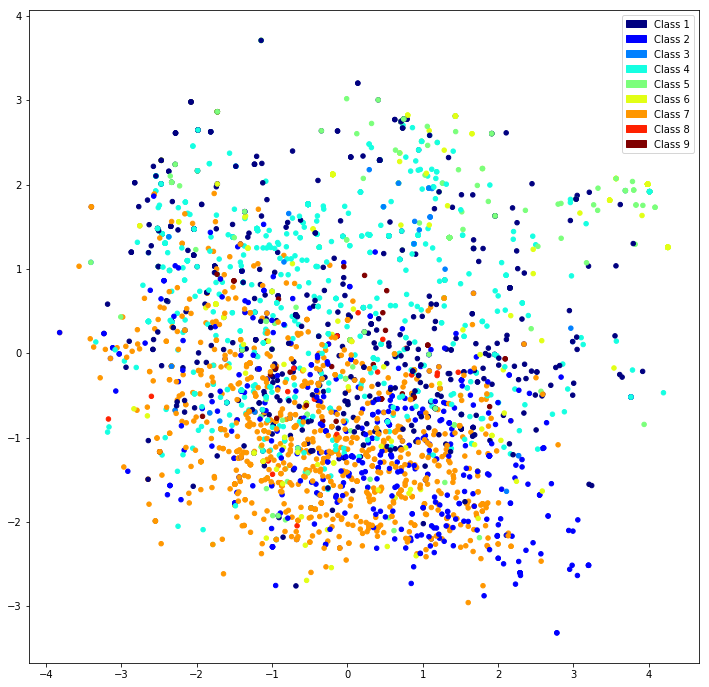

In [15]:
pca = PCA(n_components=2)
reduced_vecs = pca.fit_transform(text_wv_mean)

from matplotlib.patches import Patch

fig = plt.figure(figsize=(12,12))
ax = plt.subplot(111)
cm = plt.get_cmap('jet', 9)
colors = [cm(i/9) for i in range(9)]
ax.scatter(reduced_vecs[:,0], reduced_vecs[:,1], c=[colors[c-1] for c in classes], cmap='jet', s=20)
#plt.legend(['Class ' +str(i+1) for i in range(9)])
plt.legend(handles=[Patch(color=colors[i], label='Class {}'.format(i+1)) for i in range(9)])

not very good clustering; however, trying with more PCAs, better vector extraction (not mean w2v), 
and a better w2v model (pubmed) should do a better job; also word extraction can be improved to get the more complex words; how about ngrams?

In [23]:
forest = RandomForestClassifier(n_estimators=300, class_weight="balanced") 
forest = forest.fit(text_wv_mean, train_variants["Class"])

result_tr = forest.predict(text_wv_mean)
print("corr between prediction and real: ", np.corrcoef(result_tr, np.array(train_variants["Class"]))[0,1])

scores = cross_val_score(forest, text_wv_mean, train_variants["Class"], cv=10)
print(scores)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std()))

corr between prediction and real:  0.861698303807
[ 0.4375      0.48809524  0.38323353  0.42942943  0.37237237  0.45180723
  0.51359517  0.62424242  0.57446809  0.44036697]
Accuracy: 0.47 (+/- 0.08)


In [22]:
forest = RandomForestClassifier(n_estimators=200) 
forest = forest.fit(text_wv_mean, train_variants["Class"])

result_tr = forest.predict(text_wv_mean)
print("corr between prediction and real: ", np.corrcoef(result_tr, np.array(train_variants["Class"]))[0,1])

scores = cross_val_score(forest, text_wv_mean, train_variants["Class"], cv=10)
print(scores)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std()))

corr between prediction and real:  0.876961649703
[ 0.44642857  0.46130952  0.47305389  0.43243243  0.36936937  0.38253012
  0.48338369  0.61212121  0.58054711  0.44954128]
Accuracy: 0.47 (+/- 0.07)


In [29]:
forest = RandomForestClassifier(n_estimators=100) 
forest = forest.fit(text_wv_mean, train_variants["Class"])

result_tr = forest.predict(text_wv_mean)
print("corr between prediction and real: ", np.corrcoef(result_tr, np.array(train_variants["Class"]))[0,1])

scores = cross_val_score(forest, text_wv_mean, train_variants["Class"], cv=10)
print(scores)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std()))

corr between prediction and real:  0.876469579554
[ 0.4047619   0.5         0.44610778  0.43843844  0.3963964   0.42168675
  0.48338369  0.62424242  0.55319149  0.40672783]
Accuracy: 0.47 (+/- 0.07)


In [38]:
forest = RandomForestClassifier(n_estimators=500) 
forest = forest.fit(text_wv_mean, train_variants["Class"])

result_tr = forest.predict(text_wv_mean)
print("corr between prediction and real: ", np.corrcoef(result_tr, np.array(train_variants["Class"]))[0,1])

scores = cross_val_score(forest, text_wv_mean, train_variants["Class"], cv=10, n_jobs=2)
print(scores)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std()))

corr between prediction and real:  0.877660444386
[ 0.45833333  0.5         0.46107784  0.43843844  0.38738739  0.40361446
  0.49546828  0.63939394  0.58966565  0.44648318]
Accuracy: 0.48 (+/- 0.07)


In [26]:
fname = '../data/test_text'
test_text = get_cleaned_text2(fname)
test_data_features = np.empty(shape=(len(test_text), w2v_model.layer1_size))
for i, text in enumerate(test_text):
    test_data_features[i,:] = np.array([w2v_model.wv[w] for w in text if w in w2v_model.wv.vocab]).mean(axis=0)


In [39]:
result = forest.predict(test_data_features)
result_mat = np.zeros((len(result), 9))
    
test_id = np.arange(len(result))

result_mat[test_id, result-1] = 1
result_mat = result_mat.astype(int)
output = pd.DataFrame( data={"ID":test_id, "class1":result_mat[:,0],
        "class2":result_mat[:,1],
        "class3":result_mat[:,2],
        "class4":result_mat[:,3],
        "class5":result_mat[:,4],
        "class6":result_mat[:,5],
        "class7":result_mat[:,6],
        "class8":result_mat[:,7],
        "class9":result_mat[:,8]
        } )
output.to_csv( "w2v_on_text.csv", index=False)